# Soccer data analysis

Plots from soccer data by [A. Buscema](https://github.com/Yotsumi) and [L. Ferrero Merlino](https://github.com/leonardo-fm)

In [233]:
# Required libraries
if False:
    %pip install matplotlib
    %pip install seaborn
    %pip install pandas
    %pip install numpy
    %pip install pymongo
    %pip install psycopg2
    %pip install geopandas

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
from pymongo import MongoClient
import psycopg2
from datetime import datetime

# MongoDB connection

In [187]:
mongoClient = MongoClient("localhost", 27017) 

soccerDb = mongoClient.soccer
soccerDb.list_collection_names()

['game_lineups', 'chat', 'appearances', 'game_events', 'player_valuations']

# PostgreSQL connection

In [188]:
postgresConn = psycopg2.connect("dbname=ium_tweb user=postgres password=admin")

sqlCursor = postgresConn.cursor()
sqlCursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")
sqlCursor.fetchall()

[('club',),
 ('competition',),
 ('game',),
 ('player',),
 ('socceruser',),
 ('search_v',)]

# Loading data

In [189]:
# Fetch needed data

sqlCursor.execute("SELECT * FROM player")
players = pd.DataFrame(sqlCursor.fetchall())
players = players.rename(columns={0 : "player_id", 1 : "first_name", 2 : "last_name", 3 : "name", 4 : "last_season", 5 : "current_club_id", 6 : "player_code", 7 : "country_of_birth", 8 : "city_of_birth", 9 : "country_of_citizenship", 10 : "date_of_birth", 11 : "sub_position", 12 : "position", 13 : "foot", 14 : "height_in_cm", 15 : "market_value_in_eur", 16 : "highest_market_value_in_eur", 17 : "contract_expiration_date", 18 : "agent_name", 19 : "image_url", 20 : "url", 21 : "current_club_domestic_competition_id", 22 : "current_club_name"})

sqlCursor.execute("SELECT * FROM club")
clubs = pd.DataFrame(sqlCursor.fetchall())
clubs = clubs.rename(columns={0 : "club_id", 1 : "club_code", 2 : "name", 3 : "domestic_competition_id", 4 : "total_market_value", 5 : "squad_size", 6 : "average_age", 7 : "foreigners_number", 8 : "foreigners_percentage", 9 : "national_team_players", 10 : "stadium_name", 11 : "stadium_seats", 12 : "net_transfer_record", 13 : "coach_name", 14 : "last_season", 15 : "url"})

sqlCursor.execute("SELECT * FROM competition")
competitions = pd.DataFrame(sqlCursor.fetchall())
competitions = competitions.rename(columns={0 : "competition_id", 1 : "competition_code", 2 : "name", 3 : "sub_type", 4 : "type", 5 : "country_id", 6 : "country_name", 7 : "domestic_league_code", 8 : "confederation", 9 : "url"})

sqlCursor.execute("SELECT * FROM game")
games = pd.DataFrame(sqlCursor.fetchall())
games = games.rename(columns={0 : "game_id", 1 : "competition_id", 2 : "season", 3 : "round", 4 : "date", 5 : "home_club_id", 6 : "away_club_id", 7 : "home_club_goals", 8 : "away_club_goals", 9 : "home_club_position", 10 : "away_club_position", 11 : "home_club_manager_name", 12 : "away_club_manager_name", 13 : "stadium", 14 : "attendance", 15 : "referee", 16 : "url", 17 : "home_club_formation", 18 : "away_club_formation", 19 : "home_club_name", 20 : "away_club_name", 21 : "aggregate", 22 : "competition_type"})

cursor = soccerDb.appearances.find()
appearances = pd.DataFrame(list(cursor))

cursor = soccerDb.player_valuations.find()
player_valuations = pd.DataFrame(list(cursor))

In [190]:
# Closing database connections

mongoClient.close()
postgresConn.close()

# Load Shapefile for geolocalization

In [191]:
data_directory = "./country_data/ne_10m_admin_0_countries.shp"
countries_gdf = gpd.read_file(data_directory)

In [192]:
# Function to rename countries with names matching those in our dataset

def replace_country_string(df):
    df = df.replace('England', 'United Kingdom')
    df = df.replace('Scotland', 'United Kingdom')
    df = df.replace('Wales', 'United Kingdom')
    df = df.replace('United States', 'United States of America')
    df = df.replace('Serbia', 'Republic of Serbia')
    df = df.replace('Bosnia-Herzegovina', 'Bosnia and Herzegovina')
    df = df.replace('Brunei', 'Brunei Darussalam')
    df = df.replace('Cape Verde	', 'Cabo Verde')
    return df

#  Visualization of 10 (variable) best club manager

In [193]:
# Variables
topNumber = 10

In [194]:
# Take all games
allGames = games[['home_club_goals', 'away_club_goals', 'home_club_manager_name', 'away_club_manager_name']]
allGames.dropna()

# Getting winning managers
winningHomeManager = allGames[allGames['home_club_goals'] > allGames['away_club_goals']]['home_club_manager_name']
winningAwayManager = allGames[allGames['home_club_goals'] < allGames['away_club_goals']]['away_club_manager_name']

# Merged data
winningManagers = pd.Series(pd.concat([winningHomeManager, winningAwayManager]))

# Taking first x
winningManagers = winningManagers.value_counts().reset_index().head(topNumber)
winningManagers.columns = ['manager_name', 'wins']

winningManagers

,manager_name,wins
0,Pep Guardiola,420
1,Diego Simeone,360
2,Jürgen Klopp,349
3,Carlo Ancelotti,325
4,Unai Emery,313
5,Massimiliano Allegri,291
6,José Mourinho,285
7,Brendan Rodgers,280
8,Jorge Jesus,271
9,Erik ten Hag,261


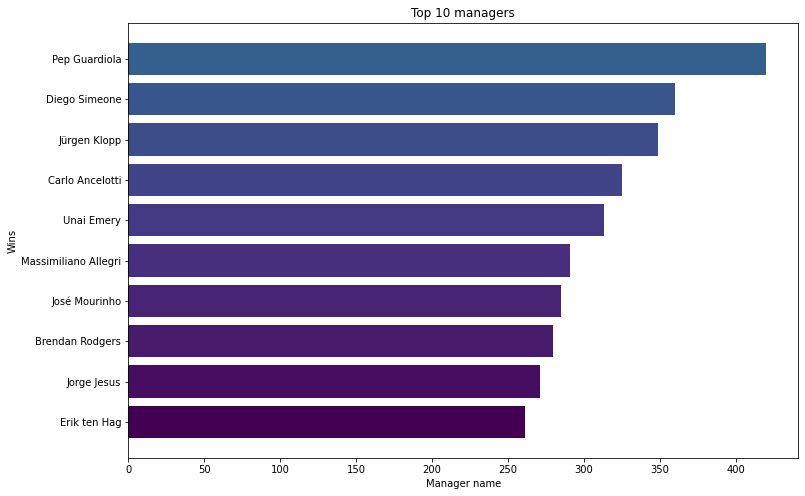

In [195]:
# Creating bar plot
winningManagers = winningManagers[::-1] # Reversing the list
colors = plt.cm.viridis(np.linspace(0, .3, len(winningManagers)))
plt.figure(figsize=(12, 8))
plt.barh(winningManagers["manager_name"], winningManagers["wins"], color=colors)

# Customize the plot
plt.title("Top " + str(topNumber) + " managers")
plt.xlabel("Manager name")
plt.ylabel("Wins")
plt.show()

# Plot representing the **relationship** between the *time spent* on the field by a player and their *age* in one year

In [196]:
# Variables
yearOfSelection = 2022

In [197]:
# Calculate player age in yearOfSelection
playersData = players[['player_id', 'date_of_birth']].copy()
playersData.dropna()
playersData['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
playersData['age'] = (pd.to_datetime(str(yearOfSelection) + '-01-01') - playersData['date_of_birth']).dt.days / 365.25
playersData = playersData[['player_id', 'age']]
playersData

,player_id,age
0,598,42.743326
1,670,42.962355
2,1323,39.321013
3,3195,38.962355
4,3259,42.836413
...,...,...
30297,371851,22.904860
30298,537171,20.334018
30299,586756,19.416838
30300,704692,18.036961


In [198]:
# Get player avg played time in yearOfSelection
appearancesData = appearances.loc[pd.to_datetime(appearances['date']).dt.year == 2022, ['player_id', 'minutes_played']]
appearancesData = appearancesData.groupby('player_id')['minutes_played'].mean().reset_index()
appearancesData

,player_id,minutes_played
0,3333,31.076923
1,3455,25.250000
2,4188,26.250000
3,4311,90.000000
4,4391,90.000000
...,...,...
7834,1050852,45.000000
7835,1056907,23.250000
7836,1059440,12.000000
7837,1059630,16.000000


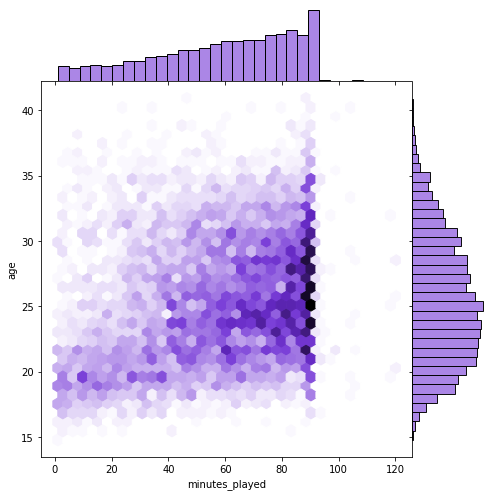

In [199]:
# Aggregate data
mergedData = pd.merge(playersData, appearancesData, on='player_id', how='inner')

#draw plot
sns.jointplot(x=mergedData['minutes_played'], y=mergedData['age'], kind="hex", color="#8f5dde", space=0, height=7, )

# Plot representing the *Serie A* rankings in one year

In [200]:
# Get Italian clubs
italianClubs = clubs.loc[clubs['domestic_competition_id'] == 'IT1', ['club_id', 'name']]

# Get played game in Serie A in 2022
italianGamesData = games.loc[(games['season'] == 2022) & (games['competition_id'] == 'IT1'), ['home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals']]
gameData = []
for i, game in italianGamesData.iterrows():
    if game['home_club_goals'] > game['away_club_goals']:
        gameData.append([game['home_club_id'], 1])
        gameData.append([game['away_club_id'], -1])
    elif game['home_club_goals'] < game['away_club_goals']:
        gameData.append([game['home_club_id'], -1])
        gameData.append([game['away_club_id'], 1])
    else:
        gameData.append([game['home_club_id'], 0])
        gameData.append([game['away_club_id'], 0])
gameData = pd.DataFrame(gameData, columns=['club_id', 'result'])

# Aggregate data
wdl = pd.merge(gameData, italianClubs, on='club_id', how='inner')[['name', 'result']]
wdl = wdl.groupby('name')['result'].value_counts().unstack(fill_value=0)
wdl.columns = ['lose', 'draw', 'win']
wdl = wdl.sort_values(by=['win', 'draw', 'lose'], ascending=True)
wdl

,lose,draw,win
name,,,
UC Sampdoria,25,10,3
US Cremonese,21,12,5
Spezia Calcio,19,13,6
Verona Hellas Football Club,21,10,7
Unione Sportiva Lecce,18,12,8
U.S. Salernitana 1919 S.r.l.,14,15,9
Empoli Football Club S.r.l.,15,13,10
Udinese Calcio,14,13,11
Unione Sportiva Sassuolo Calcio,17,9,12


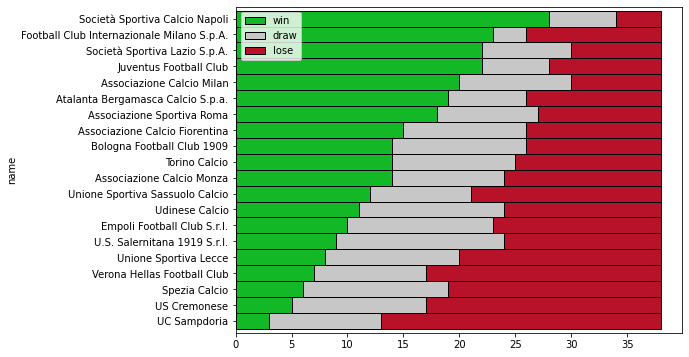

In [201]:
# Draw plot
wdl = wdl.loc[:, ::-1] # Revers order of the columns diaply
fig, ax = plt.subplots(figsize=(8, 6))
wdl.plot(stacked=True, kind='barh', color=['#12b826', '#c7c7c7', '#b8122b'], ax=ax, width=1, edgecolor='black') # color = [win, draw, lose]
ax.legend(loc='upper left')

# Map representing the *average market value* of players in each **competition country**

In [202]:
# Get needed player columns
playerValue = players[['player_id', 'market_value_in_eur', 'current_club_domestic_competition_id']]
playerValue = playerValue.dropna(subset='market_value_in_eur')

# Merge player with competition for getting country
competitionMerge = competitions[['competition_id', 'country_name']]
competitionMerge = replace_country_string(competitionMerge)
competitionMerge.set_index('competition_id')
playerValue = playerValue.merge(competitionMerge, how='left', left_on='current_club_domestic_competition_id', right_on='competition_id')

# Group by country name and sum the market value
playerValue = playerValue.groupby('country_name')['market_value_in_eur'].mean().reset_index(name='market_value_mean')
playerValue

,country_name,market_value_mean
0,Belgium,1.058886e+06
1,Denmark,5.729663e+05
2,France,3.320863e+06
3,Germany,3.494543e+06
4,Greece,5.697815e+05
5,Italy,2.602043e+06
6,Netherlands,1.091762e+06
7,Portugal,1.275839e+06
8,Russia,9.275481e+05
9,Spain,3.623388e+06


<Axes: >

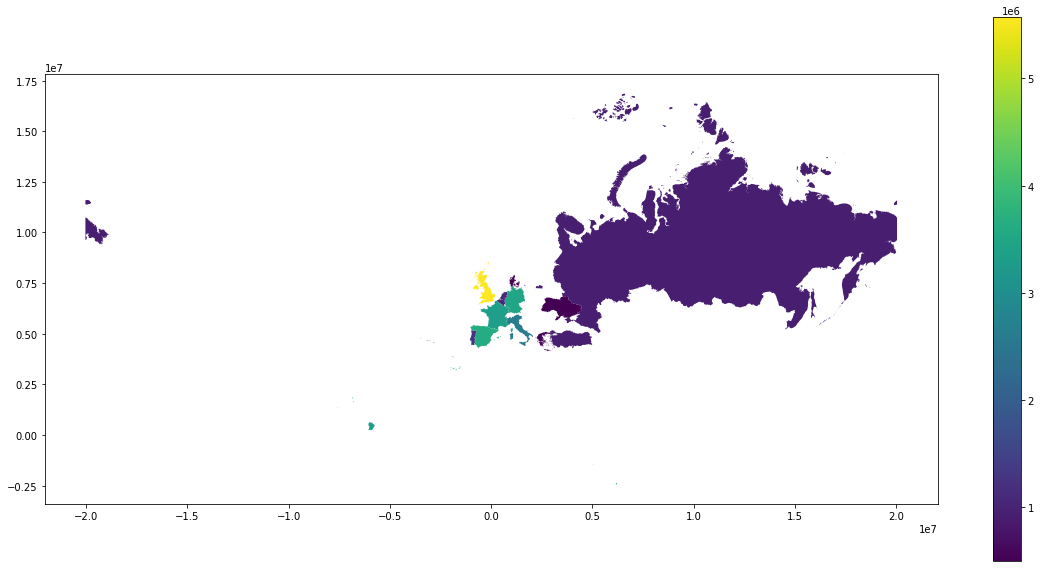

In [203]:
# Merge player data with relative country
playerValueGeo = countries_gdf.merge(playerValue, left_on='ADMIN', right_on='country_name', how='right')
playerValueGeo = playerValueGeo[['market_value_mean', 'country_name', 'geometry']]

playerValueGeo = playerValueGeo.to_crs('EPSG:3857')
playerValueGeo.plot(figsize=(20,10), edgecolor='black', linewidth=0, column='market_value_mean', legend=True)

# Map representing the *average market value* of players based on their **citizenship country**

In [204]:
#Get needed player columns
playerValue2 = players[['player_id', 'market_value_in_eur', 'country_of_citizenship']]
playerValue2 = playerValue2.dropna(subset='market_value_in_eur')
competitionMerge = replace_country_string(competitionMerge)

# Group by country name and sum the market value
playerValue2 = playerValue2.groupby('country_of_citizenship')['market_value_in_eur'].mean().reset_index(name='market_value_mean')
playerValue2

,country_of_citizenship,market_value_mean
0,Afghanistan,2.625000e+05
1,Albania,1.323578e+06
2,Algeria,3.153385e+06
3,Andorra,5.000000e+05
4,Angola,1.176596e+06
...,...,...
164,Venezuela,1.018056e+06
165,Vietnam,2.750000e+05
166,Wales,2.530488e+06
167,Zambia,2.261667e+06


<Axes: >

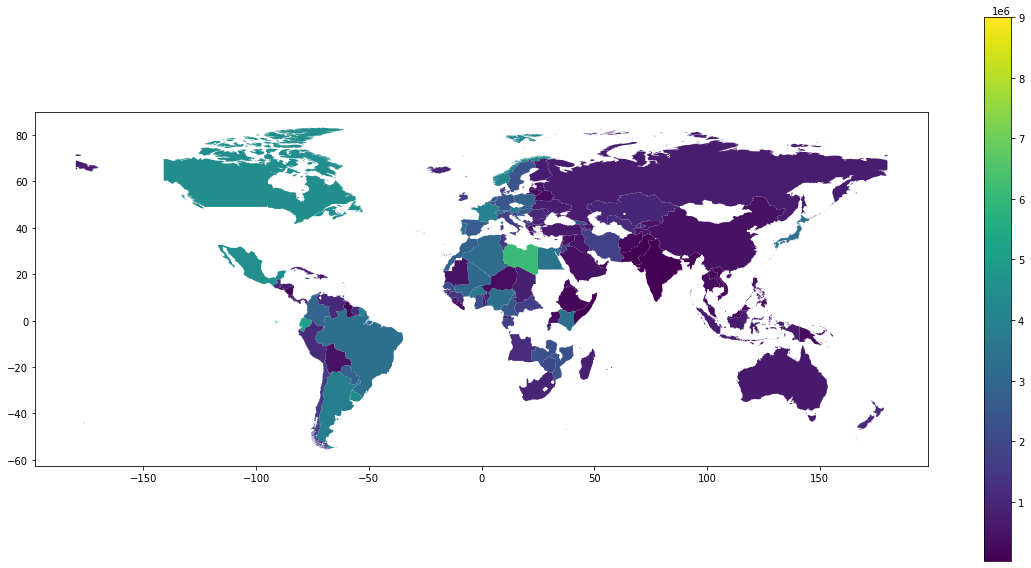

In [205]:
# Merge player data with relative country
playerValueGeo = countries_gdf.merge(playerValue2, left_on='ADMIN', right_on='country_of_citizenship', how='right')
playerValueGeo = playerValueGeo[['market_value_mean', 'country_of_citizenship', 'geometry']]

playerValueGeo.plot(figsize=(20,10), edgecolor='black', linewidth=0, column='market_value_mean', legend=True)

# Map representing the *total number of players* from each **citizenship country**

In [206]:
playerValue3 = players[['player_id', 'country_of_citizenship']]
playerValue3 = replace_country_string(playerValue3)

# Group by country name and sum the market value
playerValue3 = playerValue3.groupby('country_of_citizenship')['country_of_citizenship'].count().reset_index(name='counts')
playerValue3

,country_of_citizenship,counts
0,Afghanistan,3
1,Albania,133
2,Algeria,141
3,Andorra,1
4,Angola,62
...,...,...
173,Uzbekistan,23
174,Venezuela,68
175,Vietnam,2
176,Zambia,19


<Axes: >

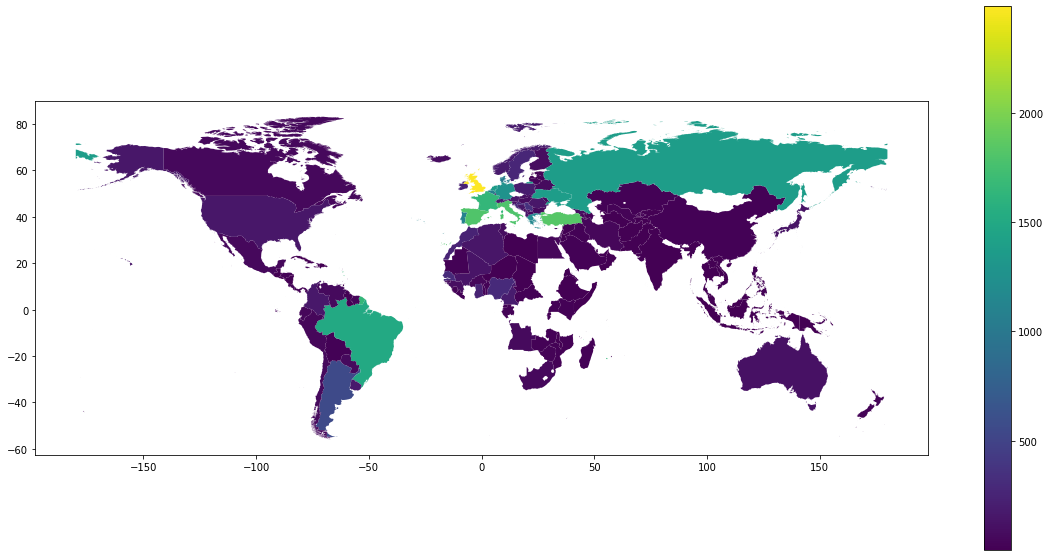

In [207]:
# Merge player data with relative country
playerValueGeo = countries_gdf.merge(playerValue3, left_on='ADMIN', right_on='country_of_citizenship', how='right')
playerValueGeo = playerValueGeo[['counts', 'country_of_citizenship', 'geometry']]

playerValueGeo.plot(figsize=(20,10), edgecolor='black', linewidth=0, column='counts', legend=True)

# Map representing the *total goals scored* by clubs in each country in one year

In [208]:
# Variables
totGoalsYear = 2022

In [209]:
gameData = games[['competition_id', 'season', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals']]
gameData = gameData[gameData['season'] == totGoalsYear]
gameData['total_goals'] = gameData['home_club_goals'] + gameData['away_club_goals']

competitionMerge = competitions[['competition_id', 'country_name']]
competitionMerge = replace_country_string(competitionMerge)
gameData = gameData.merge(competitionMerge, how='left', on='competition_id')
gameData = gameData.dropna()

countryGoals = gameData.groupby('country_name')['total_goals'].sum().reset_index()
countryGoals = countries_gdf.merge(countryGoals, left_on='ADMIN', right_on='country_name', how='right')
countryGoals

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,country_name,total_goals
0,Admin-0 country,0,2,Belgium,BEL,0,2,Sovereign country,1,Belgium,...,None,None,None,None,None,None,None,"POLYGON ((2.52180 51.08754, 2.54200 51.09687, ...",Belgium,930
1,Admin-0 country,0,4,Denmark,DN1,1,2,Country,1,Denmark,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((8.66078 54.89631, 8.66879 54.9...",Denmark,800
2,Admin-0 country,0,2,France,FR1,1,2,Country,1,France,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-54.11153 2.11427, -54.13491 2...",France,1071
3,Admin-0 country,0,2,Germany,DEU,0,2,Sovereign country,1,Germany,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((13.81572 48.76643, 13.78586 48...",Germany,1275
4,Admin-0 country,0,3,Greece,GRC,0,2,Sovereign country,1,Greece,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((20.96526 40.84939, 21.11213 40...",Greece,762
5,Admin-0 country,0,2,Italy,ITA,0,2,Sovereign country,1,Italy,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((7.02208 45.92526, 7.06694 45.8...",Italy,1146
6,Admin-0 country,0,5,Netherlands,NL1,1,2,Country,1,Netherlands,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...",Netherlands,1310
7,Admin-0 country,0,2,Portugal,PRT,0,2,Sovereign country,1,Portugal,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-7.10486 38.82719, -7.15101 38...",Portugal,932
8,Admin-0 country,0,2,Russia,RUS,0,2,Sovereign country,1,Russia,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((87.81632 49.16584, 87.71638 49...",Russia,1380
9,Admin-0 country,0,2,Spain,ESP,0,2,Sovereign country,1,Spain,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-5.34073 35.84736, -5.36290 35...",Spain,1442


<Axes: >

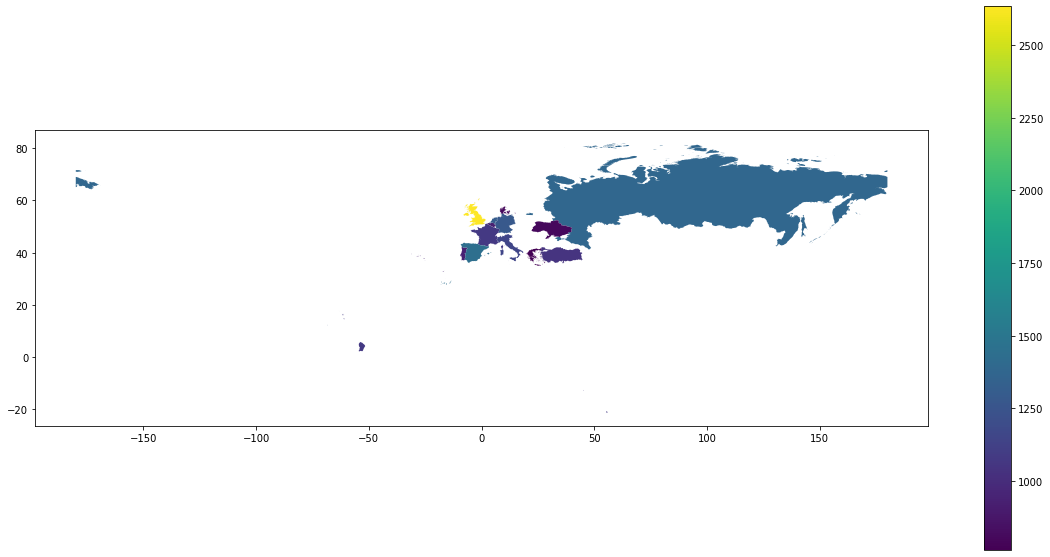

In [210]:
countryGoals.plot(figsize=(20,10), edgecolor='black', linewidth=0, column='total_goals', legend=True)

# Representing the *number of games played* each month for every year

In [211]:
gameData = games[['game_id', 'date']].copy()
gameData['year'] = pd.DatetimeIndex(gameData['date']).year
gameData['month'] = pd.DatetimeIndex(gameData['date']).month

gameData = gameData.groupby(['year', 'month'])['game_id'].count().reset_index(name='games')
gameData = gameData.pivot(index="month", columns="year", values="games")
gameData = gameData.fillna(0)
gameData = gameData.astype(int)
gameData

year,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
month,,,,,,,,,,,,
1,0,417,422,503,529,474,452,405,465,713,440,574
2,0,456,490,497,496,498,518,509,539,603,517,479
3,0,473,631,457,428,413,410,454,230,441,387,407
4,0,487,471,524,557,585,479,441,0,536,468,582
5,0,372,286,489,322,358,228,271,38,398,314,436
6,0,12,0,14,52,65,10,11,267,3,3,72
7,311,349,317,356,307,364,320,312,358,347,323,234
8,674,720,719,711,641,693,731,812,350,801,869,882
9,640,677,605,598,587,662,667,608,598,645,523,650


<Axes: xlabel='year', ylabel='month'>

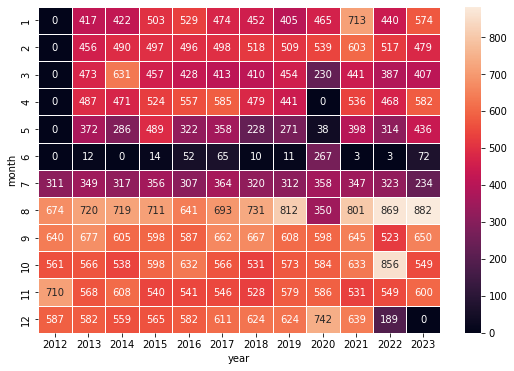

In [212]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(gameData, annot=True, fmt="d", linewidths=.5, ax=ax)

# Representing the *goals scored*, *yellow cards* and *red cards* issued per month in one year

In [213]:
# Variables
gyrYear = 2022

In [214]:
appearancesData = appearances[['appearance_id', 'yellow_cards', 'red_cards', 'goals', 'date']].copy()
appearancesData['year'] = pd.DatetimeIndex(appearancesData['date']).year
appearancesData = appearancesData[appearancesData['year'] == gyrYear]
appearancesData['month'] = pd.DatetimeIndex(appearancesData['date']).month

appearancesData = appearancesData.groupby(['year', 'month']).agg({
    'yellow_cards': 'sum',
    'red_cards': 'sum', 
    'goals': 'sum'
}).reset_index()
appearancesData

,year,month,yellow_cards,red_cards,goals
0,2022,1,1583,41,1004
1,2022,2,2091,65,1299
2,2022,3,1533,30,906
3,2022,4,1886,54,1269
4,2022,5,1171,40,913
5,2022,7,446,12,327
6,2022,8,2303,63,1534
7,2022,9,1827,51,1096
8,2022,10,3157,108,2114
9,2022,11,1591,47,1078


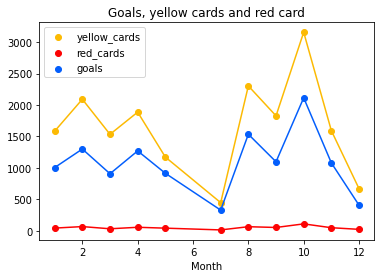

In [215]:
yellowCardColor = '#fcba03'
redCardColor = '#fc0303'
goalColor = '#035efc'

plt.scatter(appearancesData['month'], appearancesData['yellow_cards'], label='yellow_cards', color=yellowCardColor)
plt.scatter(appearancesData['month'], appearancesData['red_cards'], label='red_cards', color=redCardColor)
plt.scatter(appearancesData['month'], appearancesData['goals'], label='goals', color=goalColor)

# Collegare i punti con linee
plt.plot(appearancesData['month'], appearancesData['yellow_cards'], linestyle='-', color=yellowCardColor)
plt.plot(appearancesData['month'], appearancesData['red_cards'], linestyle='-', color=redCardColor)
plt.plot(appearancesData['month'], appearancesData['goals'], linestyle='-', color=goalColor)

plt.xlabel('Month')
plt.title('Goals, yellow cards and red card')
plt.legend()
plt.show()

# Representing the top 15 (variable) players *with the highest number of minutes played* on the field.

In [216]:
# Variables
topTimeSpentNumber = 15;

In [217]:
appearancesData = appearances[['player_name', 'minutes_played']].copy()
appearancesData = appearancesData.groupby('player_name').sum().reset_index().sort_values(by='minutes_played', ascending=False)
appearancesData = appearancesData[:topTimeSpentNumber].sort_values(by='minutes_played')
appearancesData

,player_name,minutes_played
19823,Sergio Busquets,41595
13196,Lukas Hradecky,41748
19011,Rui Patrício,42616
13146,Luis Suárez,42643
20959,Thibaut Courtois,43219
12053,Koke,43224
12765,Lionel Messi,43543
4988,David de Gea,44129
18546,Robert Lewandowski,45220
11139,João Pedro,45242


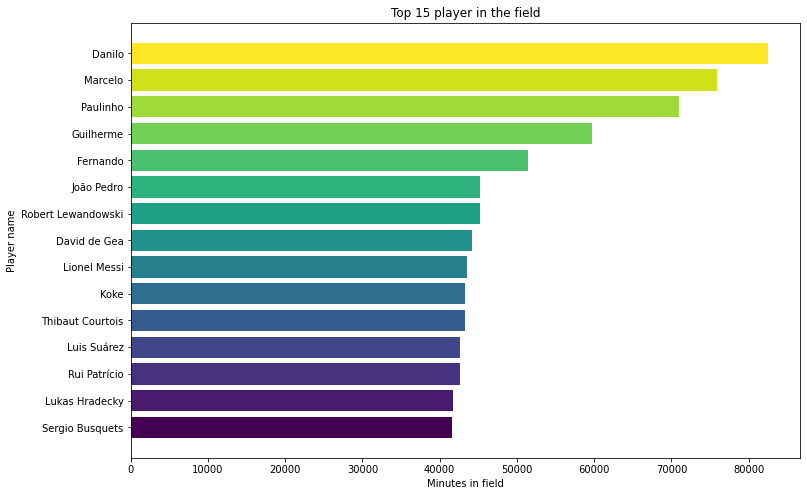

In [218]:
colors = plt.cm.viridis(np.linspace(0, 1, len(appearancesData)))
plt.figure(figsize=(12, 8))
plt.barh(appearancesData["player_name"], appearancesData["minutes_played"], color=colors)

plt.title("Top " + str(topTimeSpentNumber) + " player in the field")
plt.xlabel("Minutes in field")
plt.ylabel("Player name")
plt.show()

# Plot representing the **relationship** between the *game where scored* by an attacker and their *market value* in one year

In [219]:
# Variables
goalMktvYear = 2022
position = 'Attack'

In [220]:
appearancesData = appearances[['player_id', 'player_name', 'goals', 'date']].copy()
appearancesData['year'] = pd.DatetimeIndex(appearancesData['date']).year
appearancesData = appearancesData[appearancesData['year'] == goalMktvYear]

playersData = players[['player_id', 'position']]
playersData = playersData[playersData['position'] == position]
appearancesData = appearancesData.merge(playersData, how='inner', on='player_id')
appearancesData = appearancesData.groupby(['player_id', 'player_name'])['goals'].count().reset_index(name='total_goals')

playersValueData = players[['player_id', 'market_value_in_eur']]
appearancesData = appearancesData.merge(playersValueData, how='left', on='player_id').dropna()

# Flattening of values
appearancesData['market_value_in_eur_log'] = np.log2(appearancesData['market_value_in_eur'])
appearancesData

,player_id,player_name,total_goals,market_value_in_eur,market_value_in_eur_log
1,4188,Ricardo Quaresma,8,150000.0,17.194603
2,7161,Jonas Hofmann,27,13000000.0,23.632008
4,8198,Cristiano Ronaldo,34,15000000.0,23.838459
5,9335,Rui Fonte,26,300000.0,18.194603
7,15102,Igor Lebedenko,18,50000.0,15.609640
...,...,...,...,...,...
2225,1028566,Mert Kurt,3,75000.0,16.194603
2226,1035758,Andy Musayev,4,175000.0,17.416995
2227,1045568,Danylo Golub,4,100000.0,16.609640
2230,1056907,Mauro Couto,4,200000.0,17.609640


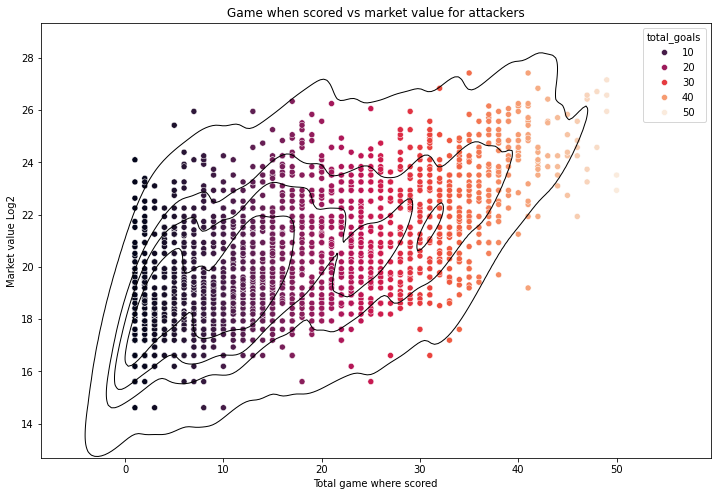

,market_value_in_eur_log,total_goals
market_value_in_eur_log,1.000000,0.608188
total_goals,0.608188,1.000000


In [236]:
# Creating scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=appearancesData["total_goals"], y=appearancesData["market_value_in_eur_log"], data=appearancesData, hue=appearancesData["total_goals"], palette="rocket")
sns.kdeplot(x=appearancesData["total_goals"], y=appearancesData["market_value_in_eur_log"], levels=5, color="black", linewidths=1)

# Customize the plot
plt.title("Game when scored vs market value for attackers")
plt.xlabel("Total game where scored")
plt.ylabel("Market value Log2")
plt.show()

appearancesData[["market_value_in_eur_log", "total_goals"]].corr()

# Representing the top 15 (variable) **most valuable clubs**

In [250]:
# Variables
mostValTop = 15

In [258]:
clubsData = clubs[['club_id', 'name', 'last_season']]

playersValueData = players[['player_id', 'last_season', 'current_club_id', 'market_value_in_eur']]
playersValueData = playersValueData.dropna()

clubsData = clubsData.merge(playersValueData, how='left', left_on=['club_id', 'last_season'], right_on=['current_club_id', 'last_season'])
clubsData = clubsData.groupby(['club_id', 'name'])['market_value_in_eur'].sum().reset_index()
clubsData = clubsData.sort_values(by='market_value_in_eur', ascending=False)
clubsData = clubsData[:mostValTop].sort_values(by='market_value_in_eur')
playersValueData

,player_id,last_season,current_club_id,market_value_in_eur
7,4042,2017,234,100000.0
33,8187,2012,2672,200000.0
72,18922,2022,418,25000000.0
89,22860,2023,678,200000.0
93,23365,2012,1387,10000.0
...,...,...,...,...
30297,371851,2023,410,10000000.0
30298,537171,2018,410,325000.0
30299,586756,2023,410,4500000.0
30300,704692,2022,410,75000.0


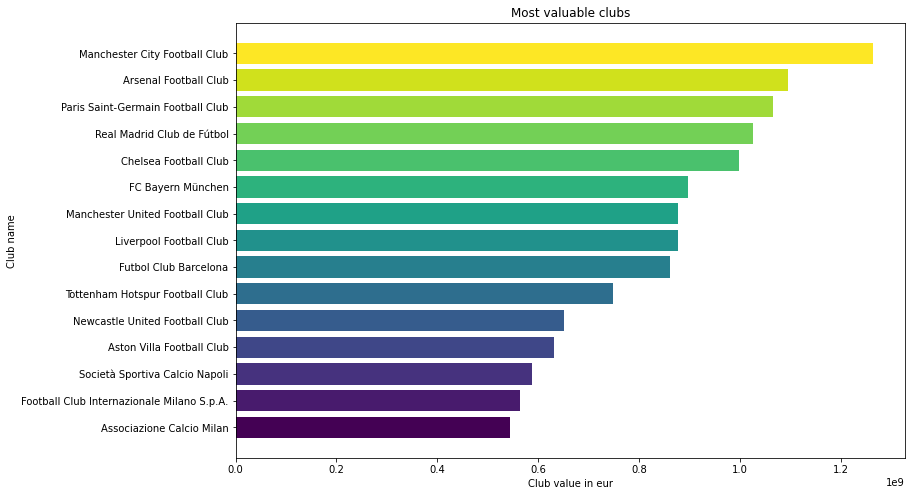

In [259]:
colors = plt.cm.viridis(np.linspace(0, 1, len(clubsData)))
plt.figure(figsize=(12, 8))
plt.barh(clubsData["name"], clubsData["market_value_in_eur"], color=colors)

plt.title("Most valuable clubs")
plt.xlabel("Club value in eur")
plt.ylabel("Club name")
plt.show()

# Representing the **average age of players** per club in one competition

In [225]:
# Variables
competition = 'IT1'

In [240]:
playersData = players[['player_id', 'last_season', 'date_of_birth', 'current_club_id']].copy()
playersData['date_of_birth'] = pd.to_datetime(playersData['date_of_birth'])
current_date = datetime.now()
playersData['age'] = (current_date - playersData['date_of_birth']).dt.days / 365.25

clubsData = clubs[['club_id', 'name', 'last_season', 'domestic_competition_id']]
clubsData = clubsData[clubsData['domestic_competition_id'] == competition]
playersData = playersData.merge(clubsData, left_on=['current_club_id', 'last_season'], right_on=['club_id', 'last_season'])

# Sort data by age
sorted_data = playersData.groupby("name")["age"].median().sort_values()
clubsData

,club_id,name,last_season,domestic_competition_id
3,12,Associazione Sportiva Roma,2023,IT1
32,1025,Bologna Football Club 1909,2023,IT1
47,410,Udinese Calcio,2023,IT1
78,458,Palermo FC,2016,IT1
79,46,Football Club Internazionale Milano S.p.A.,2023,IT1
100,3522,Spezia Calcio,2022,IT1
111,6195,Società Sportiva Calcio Napoli,2023,IT1
116,130,Parma Calcio 1913,2020,IT1
117,1429,Cesena FC,2014,IT1
123,2722,SPAL,2019,IT1


c:\Users\Nonno\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


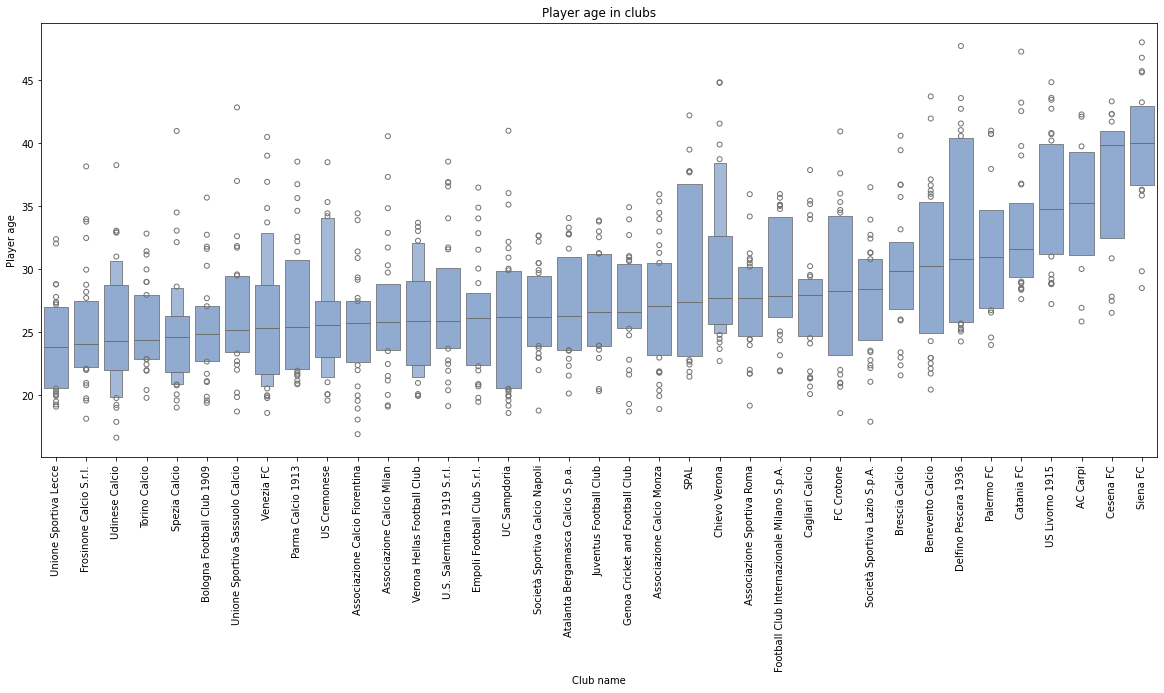

In [243]:
plt.figure(figsize=(20, 8))
sns.boxenplot(playersData, x="name", y="age", color="#86a9db", order=sorted_data.index, width_method="linear")
plt.xticks(rotation=90)

plt.title("Player age in clubs")
plt.xlabel("Club name")
plt.ylabel("Player age")
plt.show()

# Plot representing the **relationship** between the *number of stadium seats* of a club and its *market value*

In [245]:
clubsData = clubs[['club_id', 'last_season', 'name', 'stadium_seats']]

playersValueData = players[['player_id', 'last_season', 'current_club_id', 'market_value_in_eur']]
clubsData = clubsData.merge(playersValueData, how='left', left_on=['club_id', 'last_season'], right_on=['current_club_id', 'last_season']).dropna()
clubsData = clubsData.groupby(['club_id', 'name', 'stadium_seats'])['market_value_in_eur'].sum().reset_index()

# Cleaning from dirty data
clubsData = clubsData.dropna()

# Flattening of values
clubsData['market_value_in_eur'] = pd.to_numeric(clubsData['market_value_in_eur'], errors='coerce')
clubsData['market_value_in_eur_log'] = np.log2(clubsData['market_value_in_eur'])
clubsData

,club_id,name,stadium_seats,market_value_in_eur,market_value_in_eur_log
0,3,1. Fußball-Club Köln,50000,96800000.0,26.528504
1,4,1.FC Nuremberg,50000,11375000.0,23.439363
2,5,Associazione Calcio Milan,75923,543250000.0,29.017041
3,6,Adanaspor,33000,1310000.0,20.321135
4,10,Arminia Bielefeld,26515,17150000.0,24.031705
...,...,...,...,...,...
417,60949,Neos Podosferikos Syllogos Volou,22700,13075000.0,23.640308
418,61825,FK Minaj,1312,6750000.0,22.686456
419,63007,LNZ Cherkasy,10321,7050000.0,22.749192
420,68608,CF Os Belenenses,19980,1650000.0,20.654035


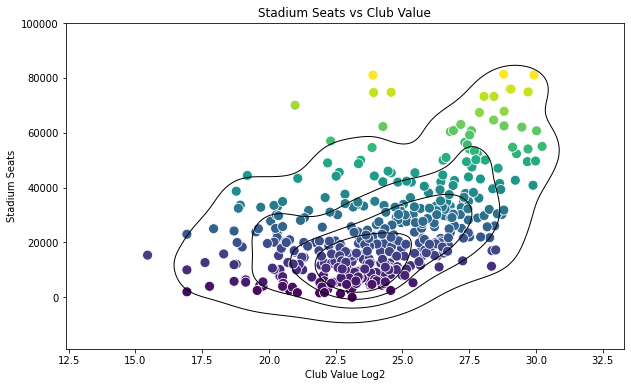

,market_value_in_eur,stadium_seats
market_value_in_eur,1.000000,0.564152
stadium_seats,0.564152,1.000000


In [246]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x="market_value_in_eur_log", y="stadium_seats", data=clubsData, hue="stadium_seats", palette="viridis", s=100, legend=False)
sns.kdeplot(x=clubsData["market_value_in_eur_log"], y=clubsData["stadium_seats"], levels=5, color="black", linewidths=1)

plt.title("Stadium Seats vs Club Value")
plt.xlabel("Club Value Log2")
plt.ylabel("Stadium Seats")
plt.show()

clubsData[["market_value_in_eur", "stadium_seats"]].corr()

# Plot representing the **percentage of role composition** of *one club* compared to all *clubs*

In [230]:
# Variables
singleClub = "Manchester City Football Club"

In [231]:
clubsData = clubs[['club_id', 'last_season', 'name']]
playersData = players[['current_club_id', 'last_season', 'position']]

clubsData = clubsData.merge(playersData, how='left', left_on=['club_id', 'last_season'], right_on=['current_club_id', 'last_season']).dropna()
clubsData = clubsData[clubsData["position"] != "Missing"]
clubsData

,club_id,last_season,name,current_club_id,position
0,105,2023,Sportverein Darmstadt 1898 e. V.,105.0,Defender
1,105,2023,Sportverein Darmstadt 1898 e. V.,105.0,Attack
2,105,2023,Sportverein Darmstadt 1898 e. V.,105.0,Defender
3,105,2023,Sportverein Darmstadt 1898 e. V.,105.0,Defender
4,105,2023,Sportverein Darmstadt 1898 e. V.,105.0,Goalkeeper
...,...,...,...,...,...
10993,984,2020,West Bromwich Albion,984.0,Defender
10994,984,2020,West Bromwich Albion,984.0,Midfield
10995,984,2020,West Bromwich Albion,984.0,Attack
10996,984,2020,West Bromwich Albion,984.0,Goalkeeper


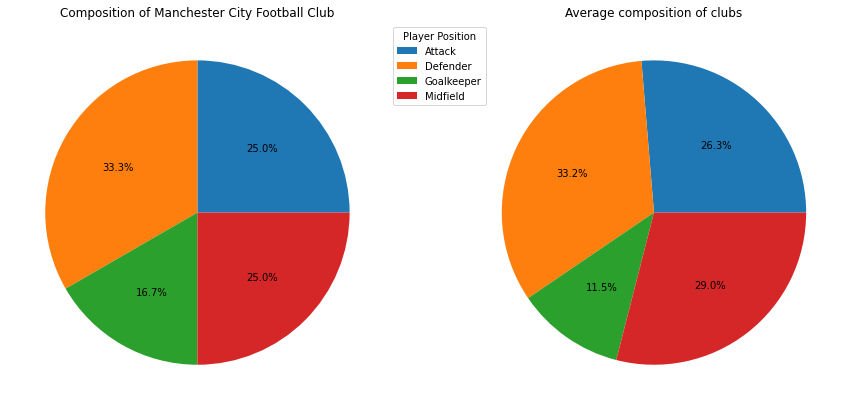

In [232]:
# Create a fig with 2 plots
fig, axes = plt.subplots(1, 2, figsize=(15, 7), facecolor='white')

# Creating pie plot for the left
clubsDataFiltered = clubsData[clubsData['name'] == singleClub]
clubsDataFiltered = clubsDataFiltered.groupby(['position'])['club_id'].count().reset_index(name='occurrence')

axes[0].pie(clubsDataFiltered["occurrence"], labels=None, autopct='%1.1f%%')
axes[0].set_ylabel('')
axes[0].set_title("Composition of " + singleClub)

# Creating pie plot for the right
clubsData = clubsData.groupby(['position'])['club_id'].count().reset_index(name='occurrence')

axes[1].pie(clubsData["occurrence"], labels=None, autopct='%1.1f%%')
axes[1].set_ylabel('')
axes[1].set_title("Average composition of clubs")

axes[0].legend(clubsData["position"], title="Player Position", loc="upper left", bbox_to_anchor=(1, 1))